In [49]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize, medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv
from scipy.ndimage import convolve
import yaml
import networkx as nx
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
import json

In [50]:
# Definición de kernels para detección de características
S1 = np.array(([0, -1, 0], [1, 1, 1], [-1, 1, -1]), dtype="int")
S2 = np.array(([0, -1, 1], [1, 1, -1], [-1, 1, 0]), dtype="int")
S3 = np.array(([0, -1, 1], [1, 1, -1], [0, -1, 1]), dtype="int")
S4 = np.array(([-1, -1, 1], [-1, 1, -1], [1, -1, 1]), dtype="int")
S1f = np.array(([-1, -1, -1], [1, 1, -1], [-1, -1, -1]), dtype="int")
S2f = np.array(([-1, -1, 1], [-1, 1, -1], [-1, -1, -1]), dtype="int")

def detector(I,S):
    I = I.astype(np.uint8)
    H = I[:,:] *0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H
        

In [51]:
def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

def separarDT(image, k):
    binary_image = (image > 0).astype(np.uint8)  # Convertir a binario
    labeled, num_features = label(binary_image)  # Etiquetar componentes conectados
    
    pixel_groups = []
    trifurcacion = []
    for i in range(1, num_features + 1):
        pixels = np.column_stack(np.where(labeled == i))  # Extraer píxeles del componente
        merged = False
        
        for group in pixel_groups:
            if any(chebyshev_distance(p, pixels[0]) <= k for p in group):
                group.extend(pixels.tolist())
                merged = True
                break
        
        if not merged:
            pixel_groups.append(pixels.tolist())
   
    new_image = np.zeros_like(image)
    new_image2 = np.zeros_like(image)
    for group in pixel_groups:
        if len(group) > 1:
            centroid = np.round(np.mean(group, axis=0)).astype(int)
            new_image[tuple(centroid)] = 255  # Marcar píxel blanco
        else:
            new_image2[tuple(group[0])] = 255  # Marcar píxel blanco
    
    return new_image, new_image2

In [52]:

def furcaciones(I):
    """
    Recive una imagen _gt y devuelve:
    D: np.array: coordenadas en la imágen de las aristas de difurcacion (conectadas a otras 3 aristas)
    T: np.array: coordenadas en la imágen de las aristas de trifurcaciones (conectadas a otras 4 aristas)
    E: np.array: coordenadas en la imágen de las aristas terminles (solo se conectan a una arista)
    
    """
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    D = np.argwhere(R0 > 0)
    T = np.argwhere(B0 > 0)
    E = np.argwhere(G0 > 0)

    # completa la parte que encuentra I 
    # 
    #
    I = 0  
    return D , T, E 


In [53]:
def get_neighbors(pixel, skeleton):
    """Obtiene los vecinos válidos de un píxel dentro del esqueleto."""
    r, c = pixel
    vecinos = [
        (r-1, c-1), (r-1, c), (r-1, c+1),
        (r, c-1),            (r, c+1),
        (r+1, c-1), (r+1, c), (r+1, c+1)
    ]
    return [p for p in vecinos if 0 <= p[0] < skeleton.shape[0] and 0 <= p[1] < skeleton.shape[1] and skeleton[p] > 0]

def dfs_find_paths(start, skeleton, nodos_especiales, visited):
    """Realiza DFS para encontrar caminos desde un nodo especial hasta otro."""
    stack = [(start, [start])]
    paths = []

    while stack:
        current, path = stack.pop()
        visited.add(current)

        for neighbor in get_neighbors(current, skeleton):
            if neighbor in visited:
                continue
            new_path = path + [neighbor]
            if neighbor in nodos_especiales:
                paths.append(new_path)
            else:
                stack.append((neighbor, new_path))

    return paths

In [54]:
def simplify_graph(G, tolerance=2):
    """
    Fusiona nodos muy cercanos según una tolerancia,
    asegurando que los nodos especiales mantengan su tipo.
    """
    New_G = G.copy()
    nodes = list(New_G.nodes(data=True))
    clusters = []
    visited = set()

    for i, (node_i, data_i) in enumerate(nodes):
        if node_i in visited:
            continue
        cluster = {node_i}
        visited.add(node_i)
        coord_i = np.array(data_i.get('coords', node_i)) if 'coords' in data_i else np.array(node_i)

        for j, (node_j, data_j) in enumerate(nodes[i+1:], start=i+1):
            if node_j in visited:
                continue
            coord_j = np.array(data_j.get('coords', node_j)) if 'coords' in data_j else np.array(node_j)
            
            # Fusionar si la distancia es menor a la tolerancia
            if np.linalg.norm(coord_i - coord_j) <= tolerance:
                cluster.add(node_j)
                visited.add(node_j)

        clusters.append(cluster)

    for cluster in clusters:
        if len(cluster) <= 1:
            continue

        # Obtener las coordenadas de todos los nodos en el cluster
        coords = [np.array(New_G.nodes[n]['coords']) if 'coords' in New_G.nodes[n] else np.array(n) for n in cluster]
        centroid = np.mean(coords, axis=0)
        rep_coord = tuple(np.round(centroid).astype(int))

        # 🔹 Conservar el tipo más importante dentro del cluster
        min_dist = float('inf')
        rep_type = "intermediate"  # Por defecto, si no hay nodos especiales
        for n in cluster:
            n_coord = np.array(New_G.nodes[n]['coords']) if 'coords' in New_G.nodes[n] else np.array(n)
            dist = np.linalg.norm(n_coord - centroid)
            tipo_nodo = New_G.nodes[n].get('type', 'intermediate')

            # Mantener el tipo de nodo especial si existe en el cluster
            if tipo_nodo in ['bifurcation', 'trifurcation', 'endpoint']:
                rep_type = tipo_nodo
                min_dist = dist  # Asegurar que el más cercano al centro sea el principal

        # Agregar el nuevo nodo fusionado con el tipo correcto
        new_node = rep_coord
        New_G.add_node(new_node, coords=new_node, type=rep_type)

        # Redirigir las conexiones al nuevo nodo
        for n in list(cluster):
            for neighbor in list(New_G.neighbors(n)):
                if neighbor in cluster:
                    continue  # Evitar conexiones internas del cluster
                New_G.add_edge(new_node, neighbor)
            if n != new_node:
                New_G.remove_node(n)  # Eliminar nodos fusionados

    return New_G


In [55]:
def crear_grafo(skeleton, D, T, E, S=10, I=20):
    """
    Agrupa píxeles del esqueleto en segmentos de longitud S
    y genera nodos intermedios en I intervalos.
    Se generan conexiones utilizando DFS para seguir la estructura del esqueleto.
    """
    skeleton_bin = (skeleton > 0).astype(np.uint8)
    labeled_skeleton, num_components = label(skeleton_bin)

    # 🔹 Convertir nodos especiales en sets y añadir su tipo
    nodos_especiales = {tuple(n): 'bifurcation' for n in D}
    nodos_especiales.update({tuple(n): 'trifurcation' for n in T})
    nodos_especiales.update({tuple(n): 'endpoint' for n in E})

    conexiones = []
    G = nx.Graph()

    def agregar_nodo(coord, tipo='intermediate'):
        """Agrega un nodo al grafo asegurando que tenga coordenadas."""
        if coord not in G.nodes:
            tipo_existente = nodos_especiales.get(coord, tipo)
            G.add_node(coord, coords=coord, type=tipo_existente)

    # 🔹 Agregar nodos especiales al grafo con su tipo
    for nodo, tipo in nodos_especiales.items():
        G.add_node(nodo, coords=nodo, type=tipo)

    visited = set()
    
    # 🔹 Buscar caminos usando DFS entre nodos especiales
    for nodo in nodos_especiales:
        if nodo not in visited:
            paths = dfs_find_paths(nodo, skeleton, nodos_especiales, visited)
            for path in paths:
                # Agregar inicio y final del camino
                agregar_nodo(path[0])
                agregar_nodo(path[-1])

                # 🔹 Si el camino es menor a S, conectarlo directamente
                if len(path) - 1 <= S:
                    G.add_edge(path[0], path[-1])
                    conexiones.append((path[0], path[-1]))
                    continue

                # 🔹 Dividir en segmentos cada I píxeles
                nodos_intermedios_segmento = []
                for i in range(0, len(path), I):
                    subsegmento = path[i:i+I]
                    if len(subsegmento) < 2:
                        continue

                    # Escoger nodo más representativo
                    mejor_nodo = min(subsegmento, key=lambda p: np.linalg.norm(np.array(p) - np.mean(subsegmento, axis=0)))

                    if mejor_nodo not in nodos_especiales and mejor_nodo not in nodos_intermedios_segmento:
                        nodos_intermedios_segmento.append(mejor_nodo)
                        agregar_nodo(mejor_nodo)

                # 🔹 Conectar nodos en el camino de manera ordenada
                for u, v in zip([path[0]] + nodos_intermedios_segmento, nodos_intermedios_segmento + [path[-1]]):
                    if u in G and v in G:
                        G.add_edge(u, v)
                        conexiones.append((u, v))

    # 🔹 Fusionar nodos cercanos para limpiar el grafo
    G = simplify_graph(G, tolerance=5)

    return G,np.array(list(G.nodes)), list(G.edges)

In [ ]:
def process_image(path,graph_name):
    # Cargar la imagen
    I = plt.imread(path)
    
    # Obtener nodos de bifurcación, trifurcación y extremos
    D, T, E = furcaciones(I)
    
    # Obtener el esqueleto de la imagen
    skeleton = skeletonize(I / 255)
    
    # Calcular nodos intermedios agrupados
    G,nodos, conexiones = crear_grafo(skeleton, D, T, E)
    
    nodos_serializables = [{"coords": tuple(map(int, nodo)) , "type": G.nodes[ tuple(map(int, nodo))].get('type', 'intermediate')} for nodo in nodos]
    conexiones_serializables = [(tuple(map(int, u)), tuple(map(int, v))) for u, v in conexiones]
    
    # Guardar la información en JSON
    grafo_json = {
        "nodes": nodos_serializables,
        "edges": conexiones_serializables
    }

    with open(f'{graph_name}.json', 'w') as f:
        json.dump(grafo_json, f, indent=4)

    # 📌 **Graficar el esqueleto junto con los nodos**
    plt.figure(figsize=(10, 10))

# Mostrar el esqueleto en gris
    plt.imshow(skeleton, cmap='gray')

# 🔹 Definir colores por tipo de nodo
    color_map = {
        "bifurcation": "red",
        "trifurcation": "blue",
        "endpoint": "green",
        "intermediate": "orange"
    }
    # 🔹 Dibujar las conexiones del grafo en morado
    for edge in conexiones_serializables:
        (y1, x1), (y2, x2) = edge
        plt.plot([x1, x2], [y1, y2], color='purple', linewidth=1.5)
        
    # 🔹 Graficar los nodos según su tipo
    for nodo in nodos_serializables:
        tipo = nodo['type']  # Obtener tipo del nodo
        color = color_map.get(tipo, "black")  # Asignar color por tipo
        y, x = nodo['coords']
        plt.scatter(x, y, color=color, s=30, label=tipo)  
    
    
    
    # Evitar etiquetas duplicadas en la leyenda
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.axis('off')  # Ocultar ejes
    plt.title("Esqueleto con Nodos y Conexiones por Tipo")
    
    # Mostrar la imagen final
    plt.show()
        

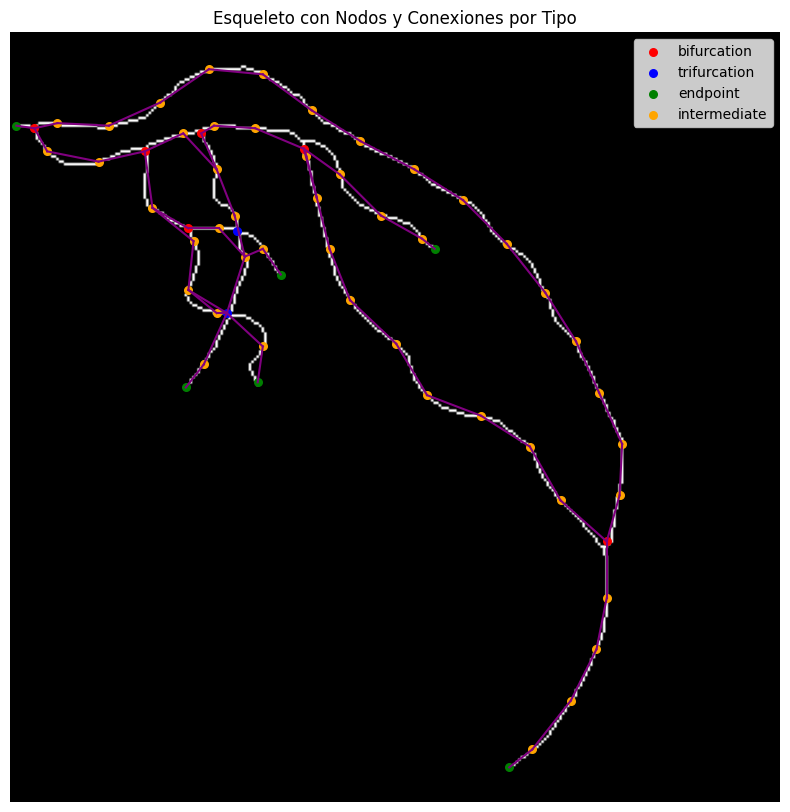

In [56]:
# Cargar la imagen
I = plt.imread('database/2_gt.pgm')

# Obtener nodos de bifurcación, trifurcación y extremos
D, T, E = furcaciones(I)

# Obtener el esqueleto de la imagen
skeleton = skeletonize(I / 255)

# Calcular nodos intermedios agrupados
G,nodos, conexiones = crear_grafo(skeleton, D, T, E)

nodos_serializables = [{"coords": tuple(map(int, nodo)) , "type": G.nodes[ tuple(map(int, nodo))].get('type', 'intermediate')} for nodo in nodos]
conexiones_serializables = [(tuple(map(int, u)), tuple(map(int, v))) for u, v in conexiones]

# Guardar la información en JSON
grafo_json = {
    "nodes": nodos_serializables,
    "edges": conexiones_serializables
}

with open(f'graph_2_aprox.json', 'w') as f:
    json.dump(grafo_json, f, indent=4)

# 📌 **Graficar el esqueleto junto con los nodos**
plt.figure(figsize=(10, 10))

# Mostrar el esqueleto en gris
plt.imshow(skeleton, cmap='gray')

# 🔹 Definir colores por tipo de nodo
color_map = {
    "bifurcation": "red",
    "trifurcation": "blue",
    "endpoint": "green",
    "intermediate": "orange"
}
# 🔹 Dibujar las conexiones del grafo en morado
for edge in conexiones_serializables:
    (y1, x1), (y2, x2) = edge
    plt.plot([x1, x2], [y1, y2], color='purple', linewidth=1.5)
    
# 🔹 Graficar los nodos según su tipo
for nodo in nodos_serializables:
    tipo = nodo['type']  # Obtener tipo del nodo
    color = color_map.get(tipo, "black")  # Asignar color por tipo
    y, x = nodo['coords']
    plt.scatter(x, y, color=color, s=30, label=tipo)  



# Evitar etiquetas duplicadas en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.axis('off')  # Ocultar ejes
plt.title("Esqueleto con Nodos y Conexiones por Tipo")

# Mostrar la imagen final
plt.show()